In [43]:
%load_ext autoreload
%autoreload 2
import umap
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#plt.rcParams.update({"text.usetex": True})
sns.set(font_scale=1.5, rc={'text.usetex' : False})
from scipy.interpolate import griddata
from sklearn.manifold import MDS
from sklearn.preprocessing import normalize
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
from common import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Functions

In [2]:
def load_distances(chromosome, gamma, alpha=108, max_clusters=20):
    dist = pd.read_csv(f"output/A1_chr{chromosome}_gamma{gamma}_alpha{alpha}_partitions_distances.txt", comment="#", sep=" ")
    dist.drop(dist[(dist.ClusterId1 > max_clusters) | (dist.ClusterId2 > max_clusters)].index, inplace=True)
    
    return dist

In [3]:
def create_distance_matrix(distances_df, n_clusters):
    row = distances_df.to_numpy()[:,0].astype(int) - 1
    col = distances_df.to_numpy()[:,1].astype(int) - 1

    distances = distances_df.to_numpy()[:,2]
    distance_matrix = np.zeros((n_clusters, n_clusters), dtype=distances.dtype)

    distance_matrix[row, col] = distances
    distance_matrix[col, row] = distances # Add transpose

    return distance_matrix

In [4]:
def create_solution_landscape(partitions, modularity, distance_matrix):
    cluster_sizes = partitions.ClusterId.value_counts(sort=False)
    solution_landscape = cluster_sizes.to_frame().rename(columns={'ClusterId': 'clustersize'})

    n_clusters = partitions.ClusterId.max()
    cluster_centers = np.empty(n_clusters)

    for cluster_id in range(1, n_clusters + 1):
        cluster_centers[cluster_id - 1] = partitions.PartitionId[(partitions.ClusterId == cluster_id).idxmax()]

    cluster_centers = cluster_centers.astype(int)
    solution_landscape['partitionid'] = cluster_centers.tolist()
    
    # partitionid - 1 ?
    solution_landscape['modularity'] = modularity[solution_landscape.partitionid - 1].tolist()
    
    #u = umap.UMAP(metric='precomputed', n_neighbors=n_clusters - 1, min_dist=threshold)
    u = umap.UMAP(metric='precomputed', min_dist=threshold, densmap=True)
    transform = u.fit_transform(distance_matrix)

    #mds = MDS(n_components=2, metric=True, dissimilarity="precomputed")
    #transform = mds.fit_transform(distance_matrix)
    #transform = normalize(transform, axis=0)

    solution_landscape['xcoord'] = transform[:, 0]
    solution_landscape['ycoord'] = transform[:, 1]
    
    return solution_landscape

# Run on one gamma

In [28]:
chromosome = 10
alpha = 75
gamma = 55
threshold = 0.1

In [29]:
gammas = get_gammas(chromosome, alphas=[alpha])[alpha]

In [30]:
partitions, max_clusters = load_partitions(chromosome, gamma, alpha, None)
#partitions

In [31]:
distances = load_distances(chromosome, gamma, alpha, max_clusters)
#distances

In [32]:
distance_matrix = create_distance_matrix(distances, max_clusters)

#plt.imshow(distance_matrix, zorder=2, cmap='Blues', interpolation='nearest')
#plt.colorbar()
#plt.title('Cluster distance matrix', fontsize=16)

In [33]:
modularity = load_modularity_scores(chromosome, gammas, alpha)[gamma]
#modularity

In [34]:
solution_landscape = create_solution_landscape(partitions, modularity, distance_matrix)
#solution_landscape

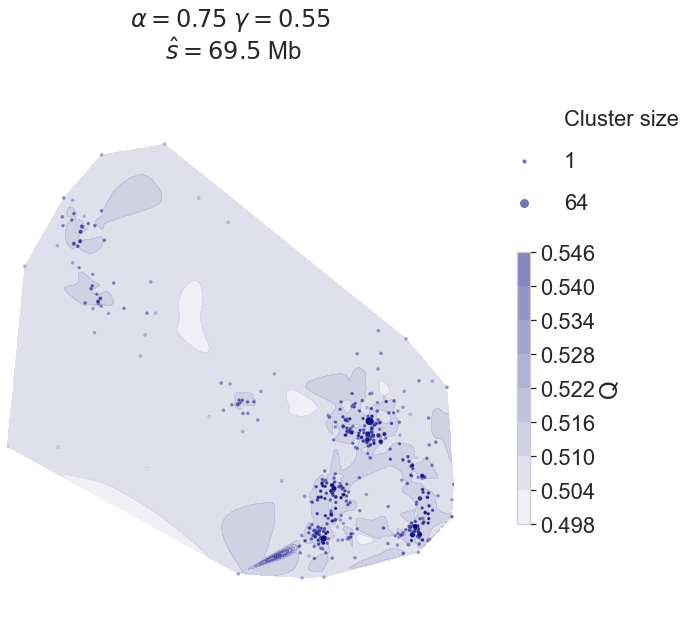

In [36]:
title = f'$\\alpha={alpha/100}$ $\gamma={gamma/100}$\n $\hat s = 69.5$ Mb'
out_name = f"results/solution_landscape_chr{chromosome}_alpha{alpha}_{gamma}.pdf"
ax = plot_solution_landscape(solution_landscape, max_clusters, title, out_name)

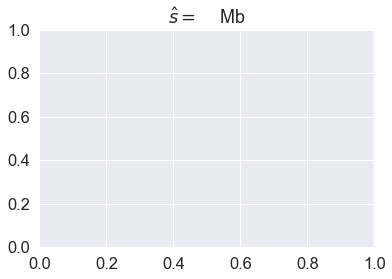

In [53]:
fig, ax = plt.subplots()
#plt.plot([1], [1])
size = "xx"
plt.title(f'$\hat s =$    Mb')
plt.savefig("/Users/anton/Downloads/shat.pdf")

# Run all gammas

In [47]:
from scipy.spatial import QhullError

modularity = load_modularity_scores(chromosome, gammas, alpha)

for gamma in gammas:
    threshold = 0.05
    modularity_ = modularity[gamma]
    # modularity_ /= 1.7791e3 # for chr5
    
    try:
        partitions, max_clusters = load_partitions(chromosome, gamma, alpha, None)
        distances = load_distances(chromosome, gamma, alpha, max_clusters)
        distance_matrix = create_distance_matrix(distances, max_clusters)
        solution_landscape = create_solution_landscape(partitions, modularity_, distance_matrix)
        title = f'chr{chromosome} $\\alpha={alpha/100}$ $\gamma={gamma/100}$'
        #out_name = f"results/solution_landscape_chr{chromosome}_{gamma}.png"
        out_name = None
        plot_solution_landscape(solution_landscape, max_clusters, title, out_name)
    except ValueError as err:
        print(err)
    except TypeError as err:
        pass
    except QhullError as err:
        pass

KeyboardInterrupt: 

# Expand small clusters to include 100 partitions

In [362]:
dist_from_best = distances[distances.ClusterId1 == 1]\
    .sort_values(by="Distance")\
    .reset_index(drop=True)\
    .drop("ClusterId1", axis=1)

sizes = partitions.ClusterId\
    .value_counts(sort=False)\
    .reset_index(drop=True)

dist_from_best["Size"] = sizes

dist_from_best

,ClusterId2,Distance,Size
0,4,0.348860,1
1,67,0.355525,1
2,16,0.359963,1
3,148,0.366779,1
4,2,0.367332,1
...,...,...,...
994,947,0.514215,1
995,904,0.515906,1
996,999,0.519758,1
997,998,0.521494,1


In [363]:
# verify that we include 100 partitions
num_values = 100
dist_from_best.head(num_values).Size.sum()

100

In [364]:
cluster_ids = dist_from_best.head(num_values).ClusterId2.sort_values().reset_index(drop=True)
cluster_ids

0       2
1       3
2       4
3       5
4       6
     ... 
95    424
96    455
97    472
98    527
99    578
Name: ClusterId2, Length: 100, dtype: int64

In [365]:
partitions = partitions[partitions.ClusterId.isin(cluster_ids)].PartitionId.values
partitions

array([  2,   3,   4,   5,   6,   8,   9,  12,  13,  15,  16,  19,  20,
        22,  24,  26,  27,  30,  31,  32,  33,  34,  35,  37,  38,  39,
        40,  42,  45,  48,  50,  52,  54,  55,  57,  59,  61,  62,  63,
        64,  66,  67,  68,  70,  71,  73,  74,  76,  77,  81,  82,  84,
        85,  88,  91, 100, 102, 103, 106, 111, 122, 124, 135, 140, 141,
       144, 145, 148, 151, 153, 167, 178, 179, 184, 187, 193, 198, 207,
       213, 214, 230, 242, 247, 248, 249, 250, 283, 296, 309, 335, 338,
       339, 376, 411, 423, 424, 455, 472, 527, 578], dtype=int32)

In [366]:
filename = f"A1_chr{chromosome}_gamma{gamma}_alpha{alpha}"
a = np.loadtxt(f"matlab/output/{filename}.csv", delimiter=" ", dtype=np.int32)

b = a[:, 0]
b = np.block([[b], [a[:, 1]]])
for partition in partitions:
    b = np.block([[b], [a[:, partition]]])
b = b.T

np.savetxt(f"output/{filename}_closest100.csv", b, delimiter=" ", fmt="%d")
run_significance_clustering(f"output/{filename}_closest100.csv", f"output/{filename}_closest100.txt")
write_partition(f"output/{filename}_closest100.txt", f"output/{filename}_closest100.stree")

Multi-level significance clustering
Running with:
	- conf: 0.9
	- seed: 123
	- output: output/A1_chr10_gamma85_closest100.txt

Reading input file... done (1355 nodes in 50 modules)
Computing similarities... done (33 ms)
Clustering... 50/50 done (194 ms)
Writing output file... done


# Fraction of significant

In [166]:
df = pd.read_csv(f"output/A1_chr{chromosome}_gamma{75}_closest100.txt", sep=" ", header=None, names=["module", "node"], dtype={"module":str, "node":np.int32})
df

,module,node
0,1;,676
1,1;,383
2,1,2
3,1,3
4,1,4
...,...,...
1350,38;,493
1351,38;,488
1352,38;,466
1353,38;,474


In [170]:
from statistics import mean, median
df["orig_module"] = df.module.str.replace(";", "").apply(lambda x: int(x))
l = [_ for _ in df.groupby("orig_module").node.count() if _ != 1]
mean(l), median(l)

(189.14285714285714, 62)

In [32]:
significant = df.module[~df.module.str.endswith(";")]
num_significant = len(significant)
num_nodes = len(df)
num_significant / num_nodes

0.9232472324723248

In [1]:
s = []

for gamma in gammas:
    try:
        df = pd.read_csv(f"output/A1_chr{chromosome}_gamma{gamma}_0.txt", sep=" ", header=None, names=["module", "node"], dtype={"module":str, "node":np.int32})
    except FileNotFoundError:
        df = pd.read_csv(f"output/A1_chr{chromosome}_gamma{gamma}_closest100.txt", sep=" ", header=None, names=["module", "node"], dtype={"module":str, "node":np.int32})
    
    significant = df.module[~df.module.str.endswith(";")]
    num_significant = len(significant)
    num_nodes = len(df)
    
    s.append(num_significant / num_nodes)

NameError: name 'gammas' is not defined

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


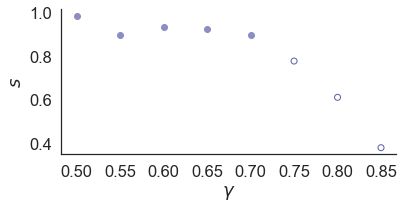

In [516]:
fig, ax = plt.subplots()
x = [g/100 for g in gammas[1:]]
ax.scatter(x[0:5], s[0:5], c=[palette(150)])
ax.scatter(x[5:], s[5:], facecolors='none', edgecolors=palette(100), marker="o")
ax.set_aspect(0.25)
ax.grid(False)
sns.despine()
plt.xlabel("$\gamma$")
plt.ylabel("$s$")
plt.xticks(x)
plt.savefig(f"results/frac_core_size_chr{chromosome}.png", dpi=600, bbox_inches="tight")